# Simulation Analysis


### 1. Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'wbx'
run_dir=''
run_dir = get_absolute_path(run_name)
print(run_dir)

/Users/reed/Projects/parflow_python_shortcourse/exercises/waterbalance/wbx


####  2. Read in the domain properties
First we will load the run from the pfidb file and get the properties using the [data_accessor](https://parflow-docs.readthedocs.io/en/latest/tutorials/data_accessor.html?highlight=data_accessor) and by reading out the keys we need from the model object. 


In [94]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz[0])

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
mannings = run.Mannings.Geom.domain.Value

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

20 30 30 30 10.0 10.0 0.05


#### 4. Read the simulation output files


In [95]:
#list all pressure files from outputs
press_files = glob(f'{run_dir}/*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(press_files) * nanmask

#list all saturation files from outputs
satur_files = glob(f'{run_dir}/*out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(satur_files) * nanmask

#list all evaptrans files from outputs
evaptrans_files = glob(f'{run_dir}/*out.evaptrans*.pfb')
#read in all pressure files into a 3D NParray
evaptrans_arrays = pf.read_pfb_sequence(evaptrans_files) * nanmask * dx*dx*dz[0]

#list all overland sum files from outputs
overlandsum_files = glob(f'{run_dir}/*out.overlandsum*.pfb')
#read in all outflow files into a 3D NParray
overlandsum_arrays = pf.read_pfb_sequence(overlandsum_files) * nanmask 
overlandflow_out = np.sum(overlandsum_arrays,axis=(1,2,3))
print(np.shape(overlandsum_arrays))
print(np.shape(overlandflow_out))

(20, 30, 30, 30)
(20,)


#### 5. Calculate water balance
We will be using the hydrology tools to calculate the water balance. You can find more information on that [here](https://parflow-docs.readthedocs.io/en/latest/tutorials/hydrology.html) 

In [104]:
subsurface_storage = np.zeros(nt)
surface_storage = np.zeros(nt)
wtd = np.zeros((nt, ny, nx))
et = np.zeros(nt)
precip=np.zeros(nt)
overland_flow = np.zeros((nt, ny, nx))
data.time = 0



for i in range(nt):
    data.time = i
    subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure_arrays[i,:,:,:], saturation_arrays[i,:,:,:], data.specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
    # total surface storage for this time step is the summation of substorage surface across all x/y slices
    surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure_arrays[i,:,:,:], dx, dy, mask = nanmask),axis=(0, 1))
    wtd[i, ...] = hydro.calculate_water_table_depth(data.pressure, data.saturation, dz)
    
    
    #if i != 0:
    #    if data.et is not None:
    #        # total ET for this time step is the summation of ET values across all x/y/z slices
    #        et[i, ...] = np.sum(hydro.calculate_evapotranspiration(data.et, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))

    #generate array of rainfall from ParFlow keys
    if (i<=run.Cycle.rainrec.r0.Length):
        precip[i]=-(run.Patch.z_upper.BCPressure.r0.Value)*(nx*dx)*(ny*dy)*run.TimeStep.Value  #  m/h over domain
    #run.Cycle.rainrec.r1.Length
    #run.Patch.z_upper.BCPressure.r1.Value

    overland_flow[i, ...] = hydro.calculate_overland_flow_grid(pressure_arrays[i,:,:], slopex, slopey, data.mannings, dx, dy, mask = nanmask, flow_method='OverlandFlow')

### Plot Static maps of the simulation outputs

(20, 30, 30)
(21, 30, 30, 30)


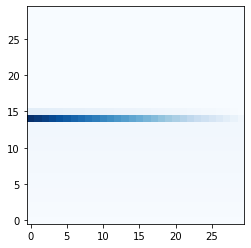

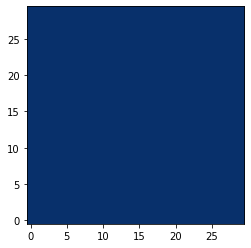

('eflx_lh_tot', 'eflx_lwrad_out', 'eflx_sh_tot', 'eflx_soil_grnd', 'qflx_evap_tot', 'qflx_evap_grnd', 'qflx_evap_soi', 'qflx_evap_veg', 'qflx_tran_veg', 'qflx_infl', 'swe_out', 't_grnd', 'qflx_qirr', 't_soil')


In [101]:
print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

plt.imshow(overland_flow[10,:,:], cmap="Blues", origin='lower')
plt.show()
plt.imshow(wtd[10,:,:], cmap="Blues_r", origin='lower')
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set time
data.time = 20
# fileter out inactive cells


### plotting components of water balance

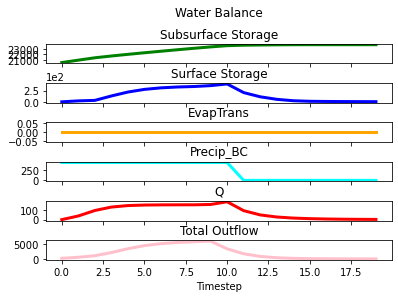

In [105]:
#plotting components of water balance
fig, axs = plt.subplots(6, sharex=True)
fig.suptitle('Water Balance')
axs[0].plot(subsurface_storage, linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage, linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et, linewidth=3, color = "orange")
axs[2].set_title("EvapTrans")
axs[3].plot(precip, linewidth=3, color = "cyan")
axs[3].set_title("Precip_BC")
axs[4].plot(overland_flow[:,15,0], linewidth=3, color = "red")
axs[4].set_title("Q")
axs[5].plot(overlandflow_out, linewidth=3, color = "pink")
axs[5].set_title("Total Outflow")
plt.xlabel('Timestep')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

In [106]:
# Sum up and make a table of the water balance
import pandas as pd

print(np.shape(overlandflow_out))

water_balance = np.zeros(20)
water_balance_percent = np.zeros(20)
outlet_flow = np.zeros(20)

for i in range(1, nt):
    #print(i)
    outlet_flow[i] = (np.sum(overland_flow[i,:,0]))*run.TimeStep.Value
    water_balance[i] = (subsurface_storage[i]+surface_storage[i])-(subsurface_storage[i-1]+surface_storage[i-1])-(precip[i]-outlet_flow[i])
    water_balance_percent[i] = (water_balance[i]/(subsurface_storage[i]+surface_storage[i]))*100


wb = pd.DataFrame({'SubStorage':subsurface_storage, 'SurStorage':surface_storage, 'OutFlow':outlet_flow,'Precip':precip, 'WaterBalance':water_balance, 'WaterBalancePercent':water_balance_percent})

print(wb)


(20,)
      SubStorage  SurStorage     OutFlow  Precip  WaterBalance  \
0   20560.456876    0.000000    0.000000   450.0  0.000000e+00   
1   20982.288417   20.794750    7.373714   450.0  5.260678e-06   
2   21402.542326   32.171313   18.369528   450.0  4.502789e-08   
3   21718.769021  130.609445   41.971627   450.0  6.636454e+00   
4   22011.154709  218.467091   87.886917   450.0  1.813025e+01   
5   22289.701224  277.936502  139.569151   450.0  2.758508e+01   
6   22559.550298  312.325491  179.249975   450.0  3.348804e+01   
7   22823.369266  331.293314  204.092887   450.0  3.687968e+01   
8   23082.672927  342.184491  218.703981   450.0  3.889882e+01   
9   23325.351417  361.801752  228.185880   450.0  4.048163e+01   
10  23542.862478  398.928364  238.585767   450.0  4.322344e+01   
11  23625.715108  205.843131  125.790592     0.0  1.555799e+01   
12  23662.709002  112.266299   61.890642     0.0  5.307703e+00   
13  23691.573851   55.528888   29.252173     0.0  1.379611e+00   
14  